# Class Imbalance

My business goal is identifying whether the company will bankrupt or not in next 1-5 years. 

I will use Ensemble Method 'XGBoost', eXtreme Gradient Boosting, for classification.

I will focus on the performance of 'recall' metric in order to minimize false negatives. Besides, I will also keep an eye on 'f1', and 'AUC' metrics.

**In this botebook, I will work on the class imbalance issue on the dataset.**

## Load Libraries

In [1]:
# Import base libraries
import pandas as pd
import numpy as np
from scipy.io import arff

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.utils import class_weight

from functions import *

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

## Data

There are five data files: 
    * data1, 1year.arff 
    * data2, 2year.arff 
    * data3, 3year.arff
    * data4, 4year.arff
    * data5, 5year.arff

Initially, I will use 'data3' to find the best approcah to handle the class imbalance. Then I will apply and re-evalate the approach in other datasets.

No cleaning applied to data. XGBoost Classifier can handle the missing values.

In [2]:
# Load data
data3 = arff.loadarff('data/3year.arff')
df3 = pd.DataFrame(data3[0])

# Change label/class  type
df3['class'] = df3['class'].astype('int64')

df3.shape

(10503, 65)

## Pre-process

In [3]:
# Assign target and predictor
y = df3['class']
X = df3.drop('class', axis=1)

# Sepearate data into train and test splist
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Scale/Normalize the predictor variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (8402, 64)
y_train shape =  (8402,)
X_test shape =  (2101, 64)
y_test shape =  (2101,)


## Baseline Model


In [5]:
# Baseline Model

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

baseline_model = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'model_1', 0, 1, 1)

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1994
           1       0.93      0.47      0.62       107

    accuracy                           0.97      2101
   macro avg       0.95      0.73      0.80      2101
weighted avg       0.97      0.97      0.97      2101



In [7]:
#Plot ROC curve

plot_ROC(3, X_train, y_train, X_test, y_test, baseline_model, 'baseline_model', 0)

NameError: name 'model_1' is not defined

In [7]:
model_1.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

**Comments**

* According to testing data results, the model performance in identfying the non-bankruptcy companies (class 0) is very good. 
* However, the identification of the bankruptcy companies (class 1) is not that good (low recall and f1)
* The class imbalance is probaly the reason for the class 0/1 performance difference.
* There is large overfitting.


## Class Imbalance

There are two approaches to deal with the class imbalance:
* 'sample_weight' parameter when training the data
* 'scale_pos_weight' parameter when initiating the classifier

### sample_weight

In [8]:
#Check Class Imbalance
df3['class'].value_counts()

0    10008
1      495
Name: class, dtype: int64

In [9]:
#Check Class Imbalance, Normalized
df3['class'].value_counts(normalize=True)

0    0.952871
1    0.047129
Name: class, dtype: float64

### scale_pos_weight

My goal is find the optimum 'scale_pos_weight' value which creates good recall and f1 value.

The model performance is largely effected by the max_depth. So I will scan the scale_pos_weight at several max_depth.

In [10]:
# Explore class counts

val_counts = df3['class'].value_counts()
ratio_imbalance = val_counts[0]/val_counts[1]
sqrt_ratio_imbalance = np.sqrt(val_counts[0]/val_counts[1])

print('imbalance ratio:', ratio_imbalance)
print('sqrt of imbalance ratio:', sqrt_ratio_imbalance)

imbalance ratio: 20.21818181818182
sqrt of imbalance ratio: 4.496463256625347


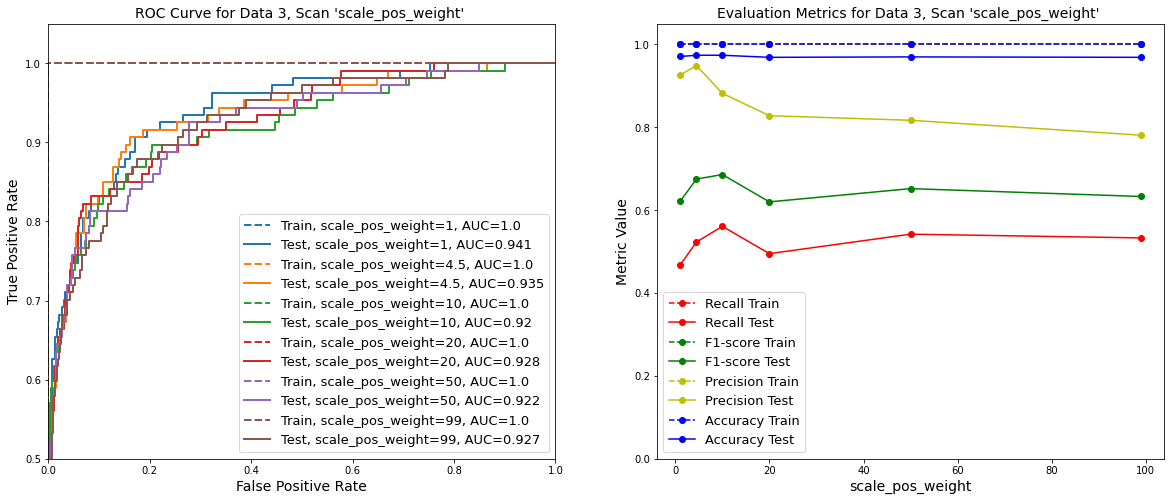

In [18]:
#Scan scale_pos_weight, default max_depth=6

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0, 1, 0)

In [5]:
# scale_pos_weight=10

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 10,
}

xgb_model_spw10 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 0, 0, 1)

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1994
           1       0.88      0.56      0.69       107

    accuracy                           0.97      2101
   macro avg       0.93      0.78      0.84      2101
weighted avg       0.97      0.97      0.97      2101



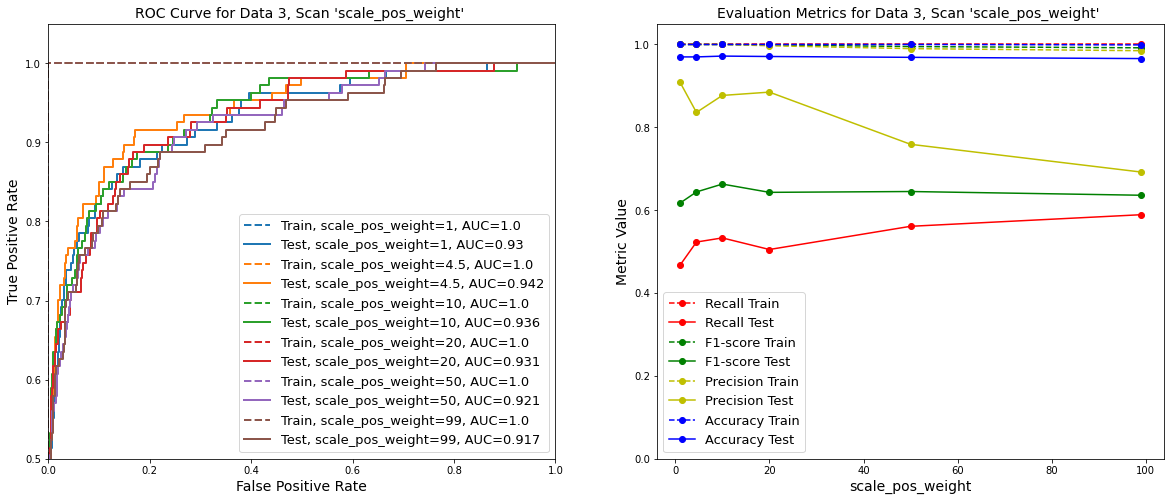

In [10]:
#Scan scale_pos_weight, default max_depth=5

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 5
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]

result_spw_depth5 = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0, 1, 0)

**Comments**
* The model performance improves compared to the baseline model (Model 1) where default scale_pos_weight=1.
* The optimum value may be different when other parameters change, for instance max_depth.
* The optimum scale_pos_weight:
    * scale_pos_weight=10 at max_depth=6
    * scale_pos_weight=50 at max_depth=5
* Overfitting observed.
* The optimum value may be different when another data set is used. It will require additional parameter tuning.

### class_weight

In [12]:
# Whole data 3
print('Whole Data3')
d3_class_weights_all = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=df3['class'])
print(d3_class_weights_all)
weights_ratio = d3_class_weights_all[1]/d3_class_weights_all[0]
print('weights_ratio', weights_ratio)
print('Squared Root of weights_ratio', np.sqrt(weights_ratio))

Whole Data3
[ 0.52473022 10.60909091]
weights_ratio 20.21818181818182
Squared Root of weights_ratio 4.496463256625347


In [13]:
#Training sample

print('Training sample')
print(class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=y_train))

d3_class_weights_train = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
print('d3 Class weights:', d3_class_weights_train)

Training sample
[ 0.52420764 10.82731959]
d3 Class weights: [0.52420764 0.52420764 0.52420764 ... 0.52420764 0.52420764 0.52420764]


In [6]:
# sample_weight

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

xgb_model_sw = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 1, 0, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1994
           1       0.87      0.54      0.67       107

    accuracy                           0.97      2101
   macro avg       0.92      0.77      0.83      2101
weighted avg       0.97      0.97      0.97      2101



**Comments**

* Compared the baseline model, model with sample_weight applied shows an improved performance, especially recall value.
* The performance is very slightly lower than to the model with scale_pos_weight applied.


### class_weight + scale_pos_weight


In [7]:
# class_weight + scale_pos_weight
# 'scale_pos_weight': 10

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 10
}
   
xgb_model_sw_spw10 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 1, 0, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       0.99      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1994
           1       0.73      0.60      0.66       107

    accuracy                           0.97      2101
   macro avg       0.85      0.79      0.82      2101
weighted avg       0.97      0.97      0.97      2101



Sample weights are used!
--------



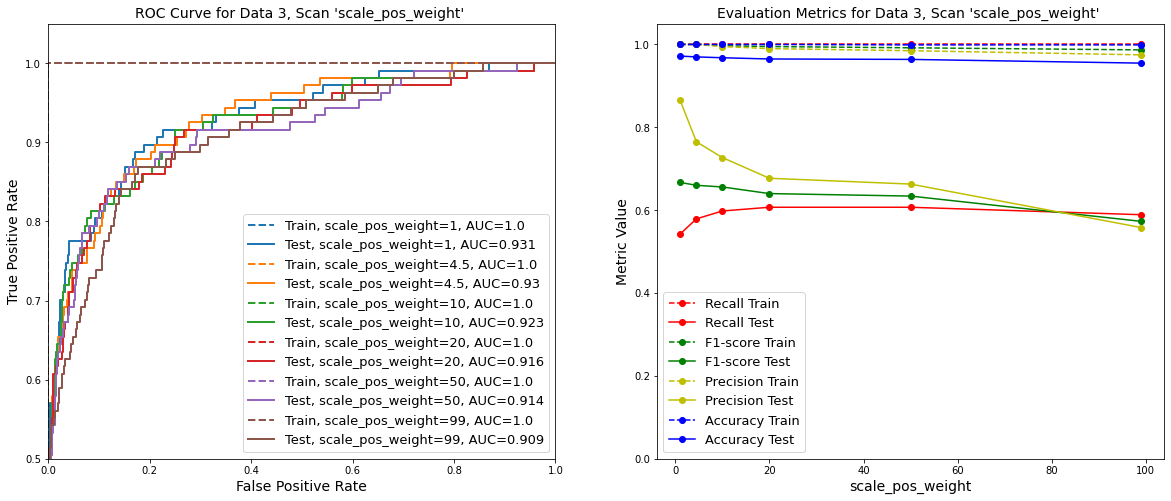

In [19]:
#Scan scale_pos_weight
# sample_weight applied
#max_depth=6

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw_sw = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

Sample weights are used!
--------



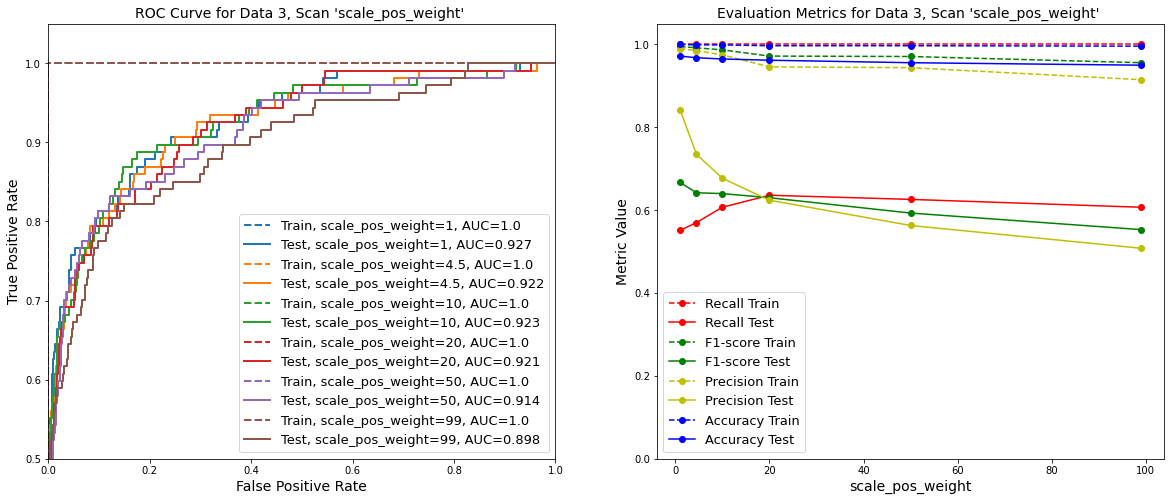

In [47]:
#Scan scale_pos_weight
# sample_weight applied
# max_depth=5

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'max_depth': 5,
}

scanParam = 'scale_pos_weight'

scanList = [1, 4.5, 10, 20, 50, 99]
#scanList = [1, 4.5]

result_spw_sw_depth5 = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)


Sample weights are used!
--------



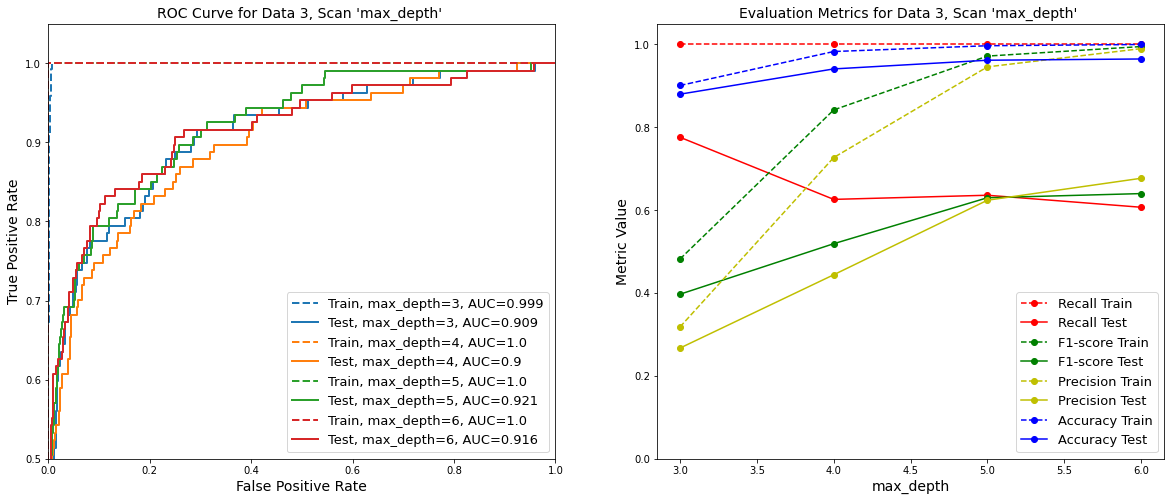

In [30]:
#Scan max_depth
# sample_weight applied
# scale_pos_weight=20

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42, 
    'scale_pos_weight': 20

}

scanParam = 'max_depth'

scanList = [3, 4, 5, 6]

result_ = scan_xgb_ROC_metrics(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1, 1, 0)

In [8]:
xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20
}
   
xgb_model_sw_spw20 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'XGB Model', 1, 0, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       0.99      1.00      0.99       388

    accuracy                           1.00      8402
   macro avg       0.99      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1994
           1       0.68      0.61      0.64       107

    accuracy                           0.97      2101
   macro avg       0.83      0.80      0.81      2101
weighted avg       0.96      0.97      0.96      2101



In [9]:
#Compare, at max_depth=6

model_list = [xgb_model_spw10, xgb_model_sw, xgb_model_sw_spw10, xgb_model_sw_spw20]

model_names_list = ['scale_pos_weight=10', 'sample_weight', 'sample_weight + scale_pos_weight=10', 'sample_weight + scale_pos_weight=20']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 'imbalance_depth6', 0, 0)


,precision,recall,f1,accuracy,auc
Params,,,,,
scale_pos_weight=10 Train,1.000,1.000,1.000,1.000,1.000
Test,0.882,0.561,0.686,0.974,0.920
sample_weight Train,1.000,1.000,1.000,1.000,1.000
Test,0.866,0.542,0.667,0.972,0.931
sample_weight + scale_pos_weight=10 Train,0.995,1.000,0.997,1.000,1.000
Test,0.727,0.598,0.656,0.968,0.923
sample_weight + scale_pos_weight=20 Train,0.990,1.000,0.995,1.000,1.000
Test,0.677,0.607,0.640,0.965,0.916


**Comments**

* Using sample_weight and scale_pos_weight together increased the performance at max_depth=6


### Model 2: Model with Class Imbalance treated

In [34]:
# Model 2: Baseline Model + sample_weight + 'scale_pos_weight=20'

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 20,
}

model_2 = xgb_model_report(3, X_train, y_train, X_test, y_test, xgbParams, 'model_2', 1, 1, 1)

Sample weights are used!
--------

Data 3 Classification Report:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       0.99      1.00      0.99       388

    accuracy                           1.00      8402
   macro avg       0.99      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1994
           1       0.68      0.61      0.64       107

    accuracy                           0.97      2101
   macro avg       0.83      0.80      0.81      2101
weighted avg       0.96      0.97      0.96      2101



In [35]:
model_2.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=20, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

,precision,recall,f1,accuracy,auc
Params,,,,,
Model 1 Train,1.000,1.000,1.000,1.000,1.000
Test,0.926,0.467,0.621,0.971,0.941
Model 2 Train,0.990,1.000,0.995,1.000,1.000
Test,0.677,0.607,0.640,0.965,0.916


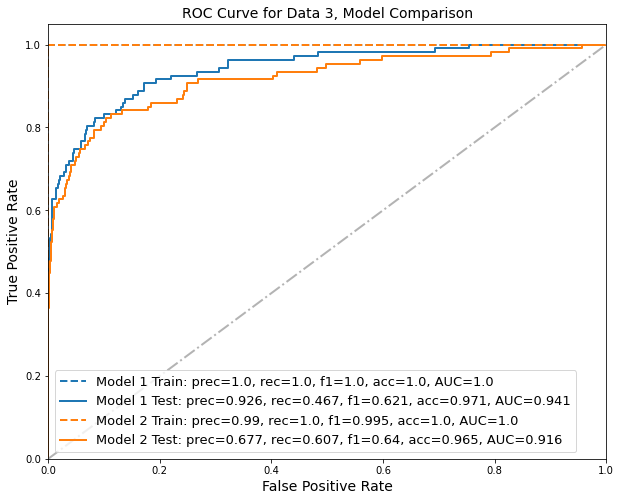

In [36]:
model_list = [model_1, model_2]
model_names_list = ['Model 1', 'Model 2']

compare_models(3, X_train, y_train, X_test, y_test, model_list, model_names_list, 1, 1)

**Comments**

* Model 2 shows an improvement compared to Model 1.
* recall and f1 increased, even though precision and AUC decreased,
* Overfitting is still strong.

## Parameter Tuning and Overfitting

The ovefitting looks a like a main issue at this point.

I will try to control overfitting by tuning the XGBoost Classifier Parameters, while trying to improve the model at the same time.

I will first use GridSearchCV on few parameters to obtain best performance parameters. Then, I will deeper look in parameters that effect overfitting.

The paramaters that can affect overfitting are grouped in four categories:

1. Boosting Rounds
    * n_estimators
2. Pruning:
    * max_depth
    * min_child_weight
    * gamma   
3. Regularization:
    * learning_rate
    * max_delta_step
    * reg_lambda
    * reg_alpha     
4. Sampling
    * subsample
    * colsample_bytree